# Machine learning model for emissions estimations from concentrations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

2021-08-25 18:58:57.527706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-25 18:58:57.527743: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In this notebook we will apply a Recurrrent Neural Network model to a dataset of concentrations in order to estimate emissions 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/ESoWC

/content/drive/My Drive/ESoWC


## Datasets

In [10]:
# Better to use os lib to change dir than magic function
import os
os.chdir('../../')

In [14]:
from src.data.make_dataset import CustomDataset

fn = 'data/totalcolConcentretations_featured+Emissions.nc'
ds = CustomDataset(fn)

Opening dataset at :  data/totalcolConcentretations_featured+Emissions.nc
Done!


Assuming data are already cleaned from NaN and error values

In [15]:
df = ds.get_dataset().to_dataframe().dropna() # drop nan because 
df = df.reset_index().drop(columns=['latitude', 'longitude']).set_index('time')
df

,NO_tc,CO2_tc,CH4_tc,NO2_tc,CO_tc,O3_tc,EMISSIONS_2019,NO_tc_add_trend,CO2_tc_add_trend,CH4_tc_add_trend,NO2_tc_add_trend,CO_tc_add_trend,O3_tc_add_trend
time,,,,,,,,,,,,,
2019-05-01 02:00:00,4.242915e-07,412.077229,1872.138289,0.000005,0.001009,0.007920,1.405082e-13,0.000001,412.620326,1878.817495,0.000003,0.001065,0.007345
2019-05-01 03:00:00,6.189903e-07,412.136477,1873.024578,0.000004,0.001010,0.007859,1.354900e-13,0.000001,412.588503,1878.369642,0.000003,0.001063,0.007345
2019-05-01 04:00:00,8.136891e-07,412.195724,1873.910866,0.000004,0.001011,0.007797,1.354900e-13,0.000001,412.556680,1877.921788,0.000003,0.001062,0.007346
2019-05-01 05:00:00,1.008388e-06,412.254971,1874.797155,0.000003,0.001012,0.007736,1.455263e-13,0.000001,412.524857,1877.473935,0.000003,0.001061,0.007346
2019-05-01 06:00:00,1.203087e-06,412.314219,1875.683443,0.000003,0.001013,0.007674,2.107622e-13,0.000001,412.493034,1877.026081,0.000003,0.001059,0.007347
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-30 04:00:00,8.918850e-07,411.606101,1828.754045,0.000004,0.000861,0.007447,6.011350e-11,0.000001,411.696930,1827.582561,0.000004,0.000845,0.007488
2019-05-30 05:00:00,1.105297e-06,411.585796,1828.908752,0.000003,0.000863,0.007429,8.706093e-11,0.000001,411.725047,1827.258201,0.000004,0.000845,0.007485
2019-05-30 06:00:00,1.318709e-06,411.565491,1829.063459,0.000003,0.000865,0.007411,2.259439e-10,0.000001,411.753164,1826.933842,0.000004,0.000845,0.007482


In [16]:
df.describe()

,NO_tc,CO2_tc,CH4_tc,NO2_tc,CO_tc,O3_tc,EMISSIONS_2019,NO_tc_add_trend,CO2_tc_add_trend,CH4_tc_add_trend,NO2_tc_add_trend,CO_tc_add_trend,O3_tc_add_trend
count,7.710070e+05,771007.000000,771007.000000,771007.000000,771007.000000,771007.000000,7.710070e+05,7.710070e+05,771007.000000,771007.000000,7.710070e+05,771007.000000,771007.000000
mean,1.152832e-06,411.058885,1839.107634,0.000004,0.000877,0.007968,1.389303e-10,1.151165e-06,411.060834,1839.187605,3.860907e-06,0.000878,0.007966
std,5.951913e-07,0.954090,11.698762,0.000002,0.000087,0.000574,2.437112e-10,1.800572e-07,0.912635,11.001448,1.283818e-06,0.000085,0.000542
min,3.080339e-08,406.511401,1787.871313,0.000001,0.000570,0.006591,4.926107e-15,7.781565e-07,407.145688,1799.198493,3.108598e-07,0.000583,0.006729
25%,6.736950e-07,410.495303,1832.186768,0.000003,0.000828,0.007595,2.523166e-11,1.039159e-06,410.510564,1832.879095,3.013398e-06,0.000832,0.007608
50%,1.264638e-06,411.219294,1839.320815,0.000004,0.000887,0.007859,7.129253e-11,1.115533e-06,411.220664,1839.077733,3.509161e-06,0.000887,0.007864
75%,1.564435e-06,411.741588,1846.178793,0.000005,0.000939,0.008225,1.740136e-10,1.215887e-06,411.716852,1845.571979,4.338641e-06,0.000937,0.008212
max,1.193310e-05,414.640254,1906.842689,0.000022,0.001149,0.010506,1.039173e-08,6.256935e-06,415.081281,1890.542741,1.651562e-05,0.001119,0.010332


# Model for all locations


Now let's try a model which takes into account all data points available. The way to do that is the following: 
- The data generator sample a tuple (latitude, longitude)
- Then fixed the location the generator sample a subsequence from the given location 

Separate target variable from independent variables

In [17]:
df_target = df['EMISSIONS_2019']
df.drop(columns=['EMISSIONS_2019'], inplace=True)

Now we have a training set with 12 features and 771007 samples

### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network.

In [18]:
x_data = df.values


In [19]:
y_data = df_target.values


This is the number of observations (aka. data-points or samples) in the data-set:

In [20]:
num_data = len(x_data)
num_data

771007

This is the fraction of the data-set that will be used for the training-set:

In [21]:
train_split = 0.7

This is the number of observations in the training-set:

In [22]:
num_train = int(train_split * num_data)
num_train

539704

This is the number of observations in the test-set:

In [23]:
num_test = num_data - num_train
num_test

231303

These are the input-signals for the training- and test-sets:

In [24]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

771007

These are the output-signals for the training- and test-sets:

In [25]:
y_train = y_data[0:num_train].reshape(-1,1)# Reshape like this if you have a single feature
y_test = y_data[num_train:].reshape(-1,1)
len(y_train) + len(y_test)

771007

This is the number of input-signals:

In [26]:
num_x_signals = x_data.shape[1]
num_x_signals

12

This is the number of output-signals:

In [27]:
y_data = y_data.reshape(-1, 1)
num_y_signals = y_data.shape[1]
num_y_signals

1

### Scaled Data

The data-set contains a wide range of values:

In [28]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 3.086117542887912e-08
Max: 1906.8426888895053


The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [29]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [30]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [31]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


We use the same scaler-object for the input-signals in the test-set.

In [32]:
x_test_scaled = x_scaler.transform(x_test)

The target-data comes from the same data-set as the input-signals, because it is the weather-data for one of the cities that is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.

In [33]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays.

In [34]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(539704, 12)
(539704, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [35]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch-size so as to keep the GPU near 100% work-load. You may have to adjust this number depending on your GPU, its RAM and your choice of `sequence_length` below.

In [36]:
batch_size = 24 #hyperparameter

In [37]:
sequence_length = 24 # 1 day of sequence, hyperparameter
sequence_length

24

We then create the batch-generator.

In [38]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can then test the batch-generator to see if it works.

In [39]:
x_batch, y_batch = next(generator)

This gives us a random batch of 24 sequences, each sequence having 24 observations, and each observation having 12 input-signals and 1 output-signals.

In [40]:
print(x_batch.shape)
print(y_batch.shape)

(24, 24, 12)
(24, 24, 1)


We can plot one of the 20 input-signals as an example.

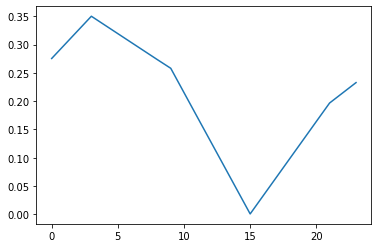

In [41]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 12 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 20 input signals.

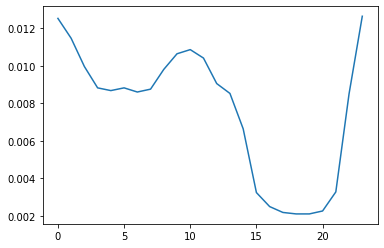

In [42]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence, this is done due to the lack of data.

In [43]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (LSTM). We will use the Keras API for this because of its simplicity.

In [44]:
model = Sequential()

2021-08-25 19:11:31.791357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-25 19:11:31.791413: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-25 19:11:31.791445: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-vidurmithal): /proc/driver/nvidia/version does not exist
2021-08-25 19:11:31.792015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can now add a Gated Recurrent Unit (GRU) to the network. This will have 64 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [45]:
model.add(LSTM(units=64,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

The GRU outputs a batch of sequences of 64 values. We want to predict 1 output-signals, so we add a fully-connected (or dense) layer which maps 64 values down to only 1 values.

The output-signal in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [46]:
model.add(Dense(num_y_signals, activation='linear'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid `NaN` values during training. You may need to experiment with this to get it working.
Since the netowrk is quite simple and shallow.

In [47]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 5 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [48]:
warmup_steps = 5

In [49]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [50]:
optimizer = Adam(lr=1e-3)

/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


We then compile the Keras model so it is ready for training.

In [51]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

This is a very small model with only two layers. The output shape of `(None, None, 1)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 1 signals. This corresponds to the target signal we want to predict.

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          19712     
_________________________________________________________________
dense (Dense)                (None, None, 1)           65        
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [53]:
path_checkpoint = 'Training_checkpoints/base_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [54]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [55]:
callback_tensorboard = TensorBoard(log_dir='./base_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

2021-08-25 19:11:38.758683: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-08-25 19:11:38.758726: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-08-25 19:11:38.761401: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [56]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.01,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [57]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.


Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [58]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=25,
          validation_data=validation_data,
          callbacks=callbacks)

2021-08-25 19:11:43.982583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
 1/25 [>.............................] - ETA: 1:14 - loss: 9.6005e-04

2021-08-25 19:11:47.104572: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-08-25 19:11:47.104618: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-08-25 19:11:47.155339: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-25 19:11:47.178876: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-08-25 19:11:49.654080: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./base_logs/train/plugins/profile/2021_08_25_19_11_47

2021-08-25 19:11:50.168093: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./base_logs/train/plugins/profile/2021_08_25_19_11_47/jupyter-vidurmithal.trace.json.gz
2021-08-25 19:11:50.182088: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./base_logs/train/plugins/profile/2021_08_25_19_11_47

2

 5/25 [=====>........................] - ETA: 30s - loss: 0.0044    

2021-08-25 19:11:53.030428: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./base_logs/train/plugins/profile/2021_08_25_19_11_47
Dumped tool data for xplane.pb to ./base_logs/train/plugins/profile/2021_08_25_19_11_47/jupyter-vidurmithal.xplane.pb
Dumped tool data for overview_page.pb to ./base_logs/train/plugins/profile/2021_08_25_19_11_47/jupyter-vidurmithal.overview_page.pb
Dumped tool data for input_pipeline.pb to ./base_logs/train/plugins/profile/2021_08_25_19_11_47/jupyter-vidurmithal.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./base_logs/train/plugins/profile/2021_08_25_19_11_47/jupyter-vidurmithal.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./base_logs/train/plugins/profile/2021_08_25_19_11_47/jupyter-vidurmithal.kernel_stats.pb



25/25 [==============================] - 38s 1s/step - loss: 0.0019 - val_loss: 5.3972e-04

Epoch 00001: val_loss improved from inf to 0.00054, saving model to Training_checkpoints/base_checkpoint.keras


OSError: Unable to create file (unable to open file: name = 'Training_checkpoints/base_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [59]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'Training_checkpoints/base_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [60]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 25s 25s/step - loss: 5.3972e-04


In [61]:
print("loss (test-set):", result)

loss (test-set): 0.0005397220375016332


In [62]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [2]:
def plot_comparison_fulltest():
    """
    Plot the predicted and true output-signals of test set
    """
    # Use test-data.
    x = x_test_scaled
    y_true = y_test
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    signal = 'EMISSIONS_2019'
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true[:]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(signal)
    plt.legend()
    plt.show()

We can now plot an example of predicted output-signal. It is important to understand what these plots show, as they are actually a bit more complicated than you might think.

In [3]:
plot_comparison_fulltest()

NameError: name 'x_test_scaled' is not defined

## Improvements

The model at least seems to perform a little better than the base model with just location, the overall performance is not sufficient yet since we train the model in the wrong way. 
Here there are the next improvements: 
- Train the model modifying the way the generator gives the data. Right now it select randomly a subsequence from the overall training set, so it is very likely that a single subsequence may contain the end of the final day for a location and the first day of the next location. So a way to improve is to force the generator to select a random subsequene from a single random location. Can be done quite easily by choosing randomly a single location (from the cartesian product of latitudes and longitudes) and than choose randomly a subsequence inside this selection.
- Right now the test set contains latitudes and longitudes never seen in the training set, shuffling smartly the dataset may solve this but pay attention to the previous point 
- Tune Hyperparameters through CROSS-VALIDATION !!
- Not use the Test set as Validation set !!